In [1]:
import copy, os, sys
import time
import random
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import myokit

sys.path.append('../')
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')

import protocol_lib
import mod_trace
import simulator_myokit
import simulator_scipy

from agetdata import get_currents_with_constant_dt
# %matplotlib inline


# seed 값 생성
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

print(torch.__version__)

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


1.9.0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if (device.type == 'cuda') and (torch.cuda.device_count() >1):
    print("Multi GPU activate")
device

device(type='cuda')

In [3]:
def get_Gfc(conc, IC50, h):
    '''This function is basically a copy of the LL.4 function from the R drc package with
    - h: hill slope
    - IC50: IC50'''  
    return 1.0+(conc/10**np.log10(IC50))**h

def get_block_rate(conc, IC50, h):
    Gfc = get_Gfc(conc, IC50, h)
    return 100 - 100.0/Gfc

def get_block_rate2(Gfc):    
    return 100 - 100/Gfc

In [ ]:
dose_response_curves_dir = "Dose_response_curves"
if not os.path.exists(dose_response_curves_dir):
    os.makedirs(dose_response_curves_dir)
    print('"%s" has been created.'%(dose_response_curves_dir))
else:
    print("The folder already exists.")    
    
results_dir = "Results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print('"%s" has been created.'%(results_dir))
else:
    print("The folder already exists.")

In [126]:
ions = {
    'INa' : 0, 
    'INaL' : 1, 
    'Ito' : 2, 
    'ICaL' : 3,
    'hERG' : 4,
    'IKs' : 5,
    'IK1' : 6
}

drug = "bepridil"
ion_channel = "hERG"
 

In [127]:
drug_block_df = pd.read_csv( "../CiPA/Hill_fitting/data/drug_block.csv") 
drug_block_df.head()

,drug,conc,units,channel,block,pacing
0,amiodarone,0.8,nM,ICaL,0.0,0.1
1,amiodarone,0.8,nM,ICaL,1.9,0.1
2,amiodarone,0.8,nM,ICaL,0.3,0.1
3,amiodarone,80.0,nM,ICaL,17.4,0.1
4,amiodarone,80.0,nM,ICaL,12.9,0.1


In [128]:
drug_ion_df = drug_block_df[(drug_block_df['drug']==drug) & (drug_block_df['channel']==ion_channel)]
drug_ion_df.head()

,drug,conc,units,channel,block,pacing
2276,bepridil,100.0,nM,hERG,58.806308,NaN
2277,bepridil,100.0,nM,hERG,55.926796,NaN
2278,bepridil,100.0,nM,hERG,59.611578,NaN
2279,bepridil,100.0,nM,hERG,65.603821,NaN
2280,bepridil,100.0,nM,hERG,70.778340,NaN


In [129]:
# xvals = np.array([5, 50, 150, 500, 1000]) # concentration
# xvals = np.array([xvals.min(), xvals.max(), plot_IC50/10, plot_IC50*10])
concs = np.linspace( np.log10(drug_ion_df['conc']).min(), np.log10(drug_ion_df['conc']).max(),  50)
concs = 10**concs

hill_df = pd.read_csv( f"../CiPA/Hill_fitting/results/{drug}/IC50_optimal.csv" )
IC50 = hill_df[f"{ion_channel}_IC50"].item()
h =  hill_df[f"{ion_channel}_h"].item()
print(IC50, h)
block_exact = get_block_rate(concs, IC50, h)
block_exact

51.34 0.9293


array([17.94279467, 18.91223135, 19.92133002, 20.97034676, 22.0593858 ,
       23.18838677, 24.35711261, 25.56513839, 26.81184132, 28.09639227,
       29.41774898, 30.77465135, 32.16561897, 33.58895114, 35.04272958,
       36.52482393, 38.03290023, 39.56443219, 41.11671546, 42.68688462,
       44.27193274, 45.86873333, 47.47406421, 49.08463308, 50.69710436,
       52.30812665, 53.91436059, 55.51250643, 57.09933099, 58.67169336,
       60.22656911, 61.76107246, 63.27247619, 64.75822903, 66.21597022,
       67.64354131, 69.0389949 , 70.40060063, 71.7268482 , 73.01644778,
       74.26832784, 75.48163075, 76.65570625, 77.79010318, 78.88455968,
       79.93899213, 80.95348324, 81.92826928, 82.863727  , 83.7603603 ])

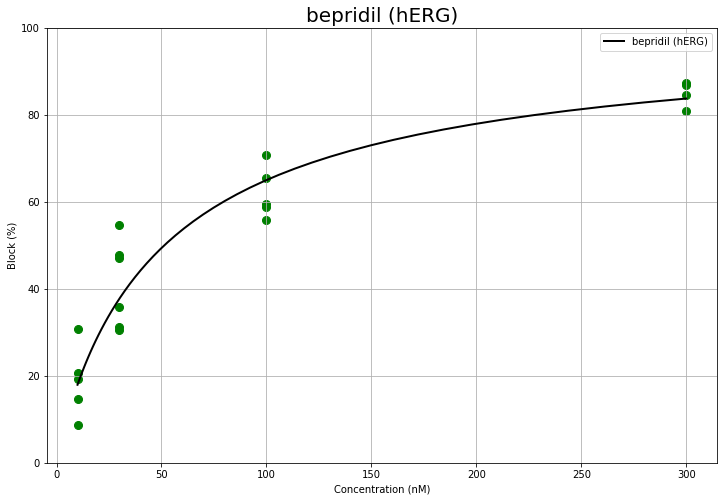

In [130]:
fig, ax = plt.subplots(1,1, figsize=(12,8))    
ax.set_title(f"{drug} ({ion_channel})", fontsize=20)
ax.set_xlabel(f'Concentration (nM)')  
ax.set_ylabel(f'Block (%)')  
ax.set_ylim(0, 100)    
ax.plot( concs, block_exact, label=f"{drug} ({ion_channel})", color='k', linewidth=2)         
ax.scatter(drug_ion_df['conc'], drug_ion_df['block'], s=64, color='g')
ax.legend()
ax.grid()
plt.plot
fig.savefig(os.path.join(dose_response_curves_dir, f"{drug}-{ion_channel}.jpg"), dpi=100)

### Current generation by simulation

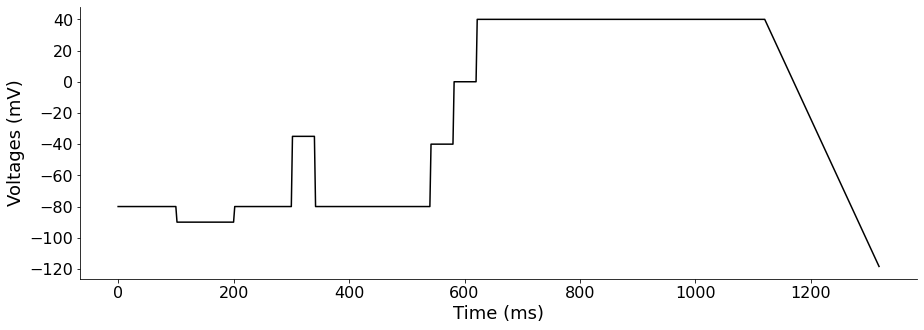

The protocol is 1320 ms


In [131]:
import vc_protocols
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()
VC_protocol = vc_protocols.leemV1_CiPA()

vhold = -80 # VC_protocol.steps[0].voltage

times = np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 2) 
VC_protocol.plot_voltage_clamp_protocol(times)
print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

In [132]:
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}

ds_params = {
    'window' : 20,
    'step_size' : 10,   
    'window_type' : 'amax',
    'noise_sigma' : 0
}  

extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL_total', 'ikr.IKr', 'iks.IKs', 'ik1.IK1']
end_time = VC_protocol.get_voltage_change_endpoints()[-1]
# t_eval = np.linspace(0, end_time, 10000)  

In [133]:
start_time = time.time()

model, p, s = myokit.load("../../../mmt-model-files/ohara-cipa-v1-2017_fixedconc-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10

f = 1.5
model_params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
   
    # 'ikr.D' : 0,
#     'ikr.Kt' : 0,
#     'ikr.Kmax' : 0,
#     'ikr.Ku' : 0,
#     'ikr.n' : 1,
#     'ikr.halfmax' : 1,    
#     'ikr.Vhalf' : 1,  
        
#     'ina.GNafc' : 1.0,  
#     'inal.GNaLfc' : 1.0/2.661,
#     'ito.Gtofc' : 1.0,
#     'ical.PCafc' : 1.0/1.007,
#     'ikr.GKrfc' : 1.1/1.114,
#     'iks.GKsfc' : 1.0/1.870,
#     'ik1.GK1fc' : 1.0/1.698,    
            
    # 'ina.Gmax_adj'  : 1.0,  
    # 'inal.Gmax_adj' : 1.0,
    # 'ito.Gmax_adj'  : 1.0,
    # 'ical.Gmax_adj' : 1.0,
    # 'ikr.Gmax_adj'  : 1.0,
    # 'iks.Gmax_adj'  : 1.0,
    # 'ik1.Gmax_adj'  : 1.0,  
    
    'ina.gNa' : 75.0 * f,   
    'inal.gNaL' : 0.0075 * 2.661 * f,  
    'ito.gto' : 0.02 * 4 * f,
    'ical.PCa' : 0.0001 * 1.007 * 2.5 * f,
    'ikr.gKr' : 4.65854545454545618e-2 * 1.3 * f, # [mS/uF]
    'iks.gKs' : 0.0034 * 1.87 * 1.4 * f,
    'ik1.gK1' : 0.1908 * 1.698 * 1.3 * f,
    'inaca.gNaCa' : 0.0008 * 1.4,
    'inak.PNaK' : 30 * 0.7,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,
}
sim.set_simulation_params(model_params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 9.99837875366211 seconds ---


In [134]:
start_time = time.time()

x_test = []

for block in block_exact:
    model_params = {      
#         'ina.Gmax_adj'  : 1.0,  
#         'inal.Gmax_adj' : 1.0,
#         'ito.Gmax_adj'  : 1.0,
#         'ical.Gmax_adj' : 1.0,
#         'ikr.Gmax_adj'  : 1.0/gfc,
#         'iks.Gmax_adj'  : 1.0,
#         'ik1.Gmax_adj'  : 1.0, 
        
        'ina.g_adj'  : (100-block)/100,  
        'inal.g_adj' : (100-block)/100,
        'ito.g_adj'  : (100-block)/100,
        'ical.g_adj' : (100-block)/100,
        'ikr.g_adj'  : (100-block)/100,
        'iks.g_adj'  : (100-block)/100,
        'ik1.g_adj'  : (100-block)/100,  
    }
    sim.set_simulation_params(model_params)  

    y0 = sim.pre_simulate(5000, sim_type=1)
    d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

    sol1 = {}
    times1 = d['engine.time']
    sol1["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
    sol1["I_total"] = d['membrane.i_ion']
    sol1["window"] = get_currents_with_constant_dt(ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )
        
    x_test.append( sol1["window"]) 

print("--- %s seconds ---"%(time.time()-start_time))

--- 4.889171123504639 seconds ---


In [135]:
# for i in range(50):
#     plt.plot(x_test[i])
# plt.show()

### Prediction

In [136]:
x_test = torch.tensor(np.array(x_test)).type(torch.float)
x_test = x_test.view(-1, x_test.shape[1], 1) 
x_test.shape

torch.Size([50, 131, 1])

In [137]:
from model3 import IonNet
model_file_path = './Trained_AI/params-495.pk'
ai_model = IonNet(seq_len = x_test.shape[1], 
               in_channels = x_test.shape[2], 
               n_parameters = 7,
               emb_size = 512,
               d_model = 512)

checkpoint = torch.load(model_file_path) 
ai_model.load_state_dict(checkpoint['model_state_dict'])
ai_model.to(device)
ai_model.eval() 
print("Go")

Loaded pretrained weights for efficientnet-b4
Go


In [138]:
Gmax_adj_pred, _, _ = ai_model(x_test.to(device))
Gmax_adj_pred = Gmax_adj_pred.cpu().detach().numpy()[:, ions[ion_channel]]
# block_pred =  get_block_rate2(Gfc=1.0/Gmax_adj_pred)    
# block_pred =  get_block_rate2(Gfc=gfcs) 
# block_pred = block_pred
block_pred = (1.0 - Gmax_adj_pred) * 100
block_pred
for i in range(len(block_pred)):
    if block_pred[i]<0:
        block_pred[i] = 0
    elif block_pred[i]>100:
        block_pred[i] = 100

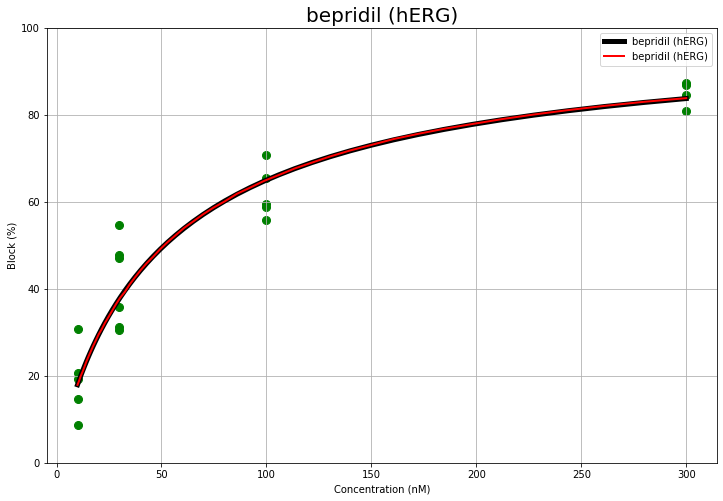

In [139]:
fig, ax = plt.subplots(1,1, figsize=(12,8))    
ax.set_title(f"{drug} ({ion_channel})", fontsize=20)
ax.set_xlabel(f'Concentration (nM)')  
ax.set_ylabel(f'Block (%)')  
ax.set_ylim(0, 100)    
ax.scatter(drug_ion_df['conc'], drug_ion_df['block'], s=64, color='g')
ax.plot( concs, block_exact, label=f"{drug} ({ion_channel})", color='k', linewidth=5)     
ax.plot( concs, block_pred, label=f"{drug} ({ion_channel})", color='r', linewidth=2) 
ax.legend()
ax.grid()
plt.plot
fig.savefig(os.path.join(dose_response_curves_dir, f"{drug}-{ion_channel}.jpg"), dpi=100)

In [140]:
print("Finish.")

Finish.
